# EEG Feature Extraction


## Importing all required libraries


In [461]:
import numpy as np
import pandas as pd
import os
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import librosa as lr
import librosa.feature as lrf
import sklearn as sk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

## Importing data

Open data (in Matlab format)

In [462]:
data_root = 'EEG Data/'

files = os.listdir(data_root)

mat = scipy.io.loadmat(data_root + files[1])

mat['o']['sampFreq'][0][0][0][0]

data = mat['o']['data'][0, 0]
FS = mat['o']['sampFreq'][0][0][0][0]

data
#bazinga

array([[ 32.,   0.,   0., ...,   0.,   0.,   0.],
       [ 33.,   0.,   0., ...,   0.,   0.,   0.],
       [ 34.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [123.,   0., 474., ...,   0.,   0.,   0.],
       [124.,   0., 459., ...,   0.,   0.,   0.],
       [125.,   0.,   0., ...,   0.,   0.,   0.]])

In [463]:
def feature_extraction(signal):
    n_mfcc = 5 
    feature_vector = []
    extracted_features = []
    # Timbral Texture Features
    feature_vector.append(lrf.spectral_centroid(signal)) # Spectral Centroid
    feature_vector.append(lrf.spectral_rolloff(signal)) # Rolloff
    feature_vector.append(lr.onset.onset_strength(signal)) # Flux
    feature_vector.append(lr.zero_crossings(signal)) # Zero Crossings
    for mfcc in lrf.mfcc(signal, n_mfcc=n_mfcc): # First 5 MFCCs
        feature_vector.append(mfcc)

    # Pitch Content Features
    n_mel = 10
    n_tonnetz = 6
    feature_vector.append(lr.beat.tempo(signal)) # Tempo
    
    for chroma in lrf.chroma_stft(signal, n_chroma=12): # First 5 MFCCs
        feature_vector.append(chroma)
        
    for mel in lr.power_to_db(lrf.melspectrogram(signal))[:n_mel, :] :
        feature_vector.append(mel)
    
    for tonal in lrf.tonnetz(signal)[:n_tonnetz, :] :
        feature_vector.append(tonal)
        
    for feature in feature_vector:
        extracted_features.append(np.mean(feature))
        extracted_features.append(np.std(feature)) 
        
    # Rhythymic Content Features
    peaks = -np.sort(-lr.onset.onset_strength(signal).flatten())
    A0 = peaks[0]
    A1 = peaks[1]
    RA = A1/A0    
    
    extracted_features.append(np.mean(lrf.tempogram(signal)))
    extracted_features.append(A0)
    extracted_features.append(A1)
    extracted_features.append(RA)
    
    return np.array(extracted_features)

Define channel names following the descripiton of the data set:

4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'

In [464]:
channel_indices = np.array(range(3, 17))
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [465]:
channel_map

{'AF3': 3,
 'F7': 4,
 'F3': 5,
 'FC5': 6,
 'T7': 7,
 'P7': 8,
 'O1': 9,
 'O2': 10,
 'P8': 11,
 'T8': 12,
 'FC6': 13,
 'F4': 14,
 'F8': 15,
 'AF4': 16}

In [435]:
df = pd.DataFrame.from_dict(data)

Plot a single channel

Text(0, 0.5, 'EEG channel AF3')

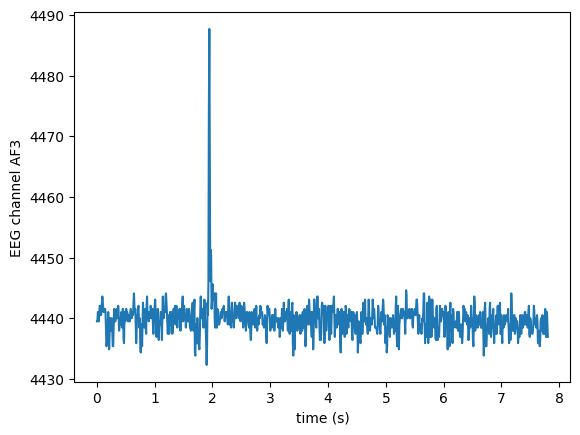

In [466]:
i_ch = 0
time = np.arange(1000) / FS
channel = data[:1000, channel_indices[i_ch]]
plt.plot(time, channel)
plt.xlabel('time (s)')
plt.ylabel(f'EEG channel {channel_names[i_ch]}')

## Extract features

Define states (according to the comments on the Data source).

The states seem to be defined arbitrarily as 10 min adjacent periods.

- 1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
- 2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
- Remaining data(t=20 min to onwards) is for "Drowsed" state

In [467]:
#burada çıkarmak istediğin state'i commentle
#burada çıkarınca X'te o state kalmıyor daha sonra aşağıda y için aynısını yapıyoruz
#aynısı bir aşağıdaki blok için de yap

states = {
  'focused': data[:FS * 10 * 60, :],
  'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
  'drowsy': data[FS * 30 * 60:, :]
}

Define frequency bands

In [468]:
#burada da çıkar

def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :]
    }
    return states

Select subjects

In [469]:
# bunu degistirin
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34]

Extract EEG features -> mean powers in delta, alpha, beta, gamma frequency bands

In [ ]:
# windowed processing
'''
rows_list = []
window_size = FS * 20 * 60
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            data = eeg[:, ch_idx]
            for i in range(len(data) - window_size + 1):
                print("new window: ", window)
                window = data[i:i+window_size]
                powers = feature_extraction(window)
                rows_list.append(powers)
'''

# brute processing
rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            data = eeg[:, ch_idx]
            print("new data: ", data)
            powers = feature_extraction(data)
            rows_list.append(powers)

In [492]:
df = pd.DataFrame.from_dict(rows_list)

## Explore and export data

Save the features to CSV file

In [493]:
#reads the data from the created csv
df.to_csv("eeg_features.csv")

In [494]:
print(df)

              0           1          2           3         4         5   \
0      66.200043  182.265216  87.059738  414.464274  0.354640  1.800302   
1      54.391798  171.324774  69.662051  388.566564  0.026082  0.022306   
2      50.161959  159.849419  61.523438  357.470617  0.090831  0.560171   
3     114.078138  169.302234  95.402072  398.455860  1.169854  1.525890   
4     101.381752  159.753208  77.362667  372.528173  1.143094  1.280544   
...          ...         ...        ...         ...       ...       ...   
1423   57.018891  170.881792  69.662051  388.914127  0.041521  0.125609   
1424   33.804919   95.056985  28.875470  207.704828  0.065996  0.385430   
1425   91.984664  164.961968  69.519447  387.781285  0.867845  0.394852   
1426   93.151961  165.070062  69.733353  388.799676  0.844736  0.444035   
1427   82.172750   90.841054  28.968020  208.630967  0.848484  0.418160   

            6         7           8          9   ...        70        71  \
0     0.000013  0.00360

In [495]:
df = pd.read_csv('eeg_features.csv')
df = df.drop('Unnamed: 0', axis=1)

In [496]:
X = df
#19th column is only 0.
#X.pop('19')

#labels vector is set up this way to match the sizes.
y = pd.read_csv('labels.csv')
y = y['state']
y = pd.concat([y,y,y,y,y,y,y])
y = y.head(1428)
y = pd.DataFrame(y) # convert from pandas series to pandas df

In [497]:
print(X)

               0           1          2           3         4         5  \
0      66.200043  182.265216  87.059738  414.464274  0.354640  1.800302   
1      54.391798  171.324774  69.662051  388.566564  0.026082  0.022306   
2      50.161959  159.849419  61.523438  357.470617  0.090831  0.560171   
3     114.078138  169.302234  95.402072  398.455860  1.169854  1.525890   
4     101.381752  159.753208  77.362667  372.528173  1.143094  1.280544   
...          ...         ...        ...         ...       ...       ...   
1423   57.018891  170.881792  69.662051  388.914127  0.041521  0.125609   
1424   33.804919   95.056985  28.875470  207.704828  0.065996  0.385430   
1425   91.984664  164.961968  69.519447  387.781285  0.867845  0.394852   
1426   93.151961  165.070062  69.733353  388.799676  0.844736  0.444035   
1427   82.172750   90.841054  28.968020  208.630967  0.848484  0.418160   

             6         7           8          9  ...        70        71  \
0     0.000013  0.00360

In [498]:
print(y)

         state
0      focused
1    unfocused
2       drowsy
3      focused
4    unfocused
..         ...
163  unfocused
164     drowsy
165    focused
166  unfocused
167     drowsy

[1428 rows x 1 columns]


In [507]:
#burada X'e yaptığımızı y için yapıyoruz
#"drowsy" yazan kısım çıkarmak istediğimiz state
#iki stringi de değiştirmen lazım

indexes = y[y == "drowsy"]
print(indexes)
nan_indexes = indexes.isna().any(axis=1).to_numpy().nonzero()[0]
print(nan_indexes)

y_2 = y[y != "drowsy"]

y_2 = y_2.dropna()
print(y_2)

       state
0        NaN
1        NaN
2     drowsy
3        NaN
4        NaN
...      ...
1423     NaN
1424  drowsy
1425     NaN
1426     NaN
1427  drowsy

[1428 rows x 1 columns]
[   0    1    3    4    6    7    9   10   12   13   15   16   18   19
   21   22   24   25   27   28   30   31   33   34   36   37   39   40
   42   43   45   46   48   49   51   52   54   55   57   58   60   61
   63   64   66   67   69   70   72   73   75   76   78   79   81   82
   84   85   87   88   90   91   93   94   96   97   99  100  102  103
  105  106  108  109  111  112  114  115  117  118  120  121  123  124
  126  127  129  130  132  133  135  136  138  139  141  142  144  145
  147  148  150  151  153  154  156  157  159  160  162  163  165  166
  168  169  171  172  174  175  177  178  180  181  183  184  186  187
  189  190  192  193  195  196  198  199  201  202  204  205  207  208
  210  211  213  214  216  217  219  220  222  223  225  226  228  229
  231  232  234  235  237  238  240  2

In [502]:
#bura gereksiz
#yukarida cikiyor zaten burada eksiltmeye gerek yok boyle daha hizli 
#hic anlatamadim ama trust me
#X_2= X.loc[nan_indexes]
#print(X_2)

               0           1          2           3         4         5  \
0      66.200043  182.265216  87.059738  414.464274  0.354640  1.800302   
1      54.391798  171.324774  69.662051  388.566564  0.026082  0.022306   
3     114.078138  169.302234  95.402072  398.455860  1.169854  1.525890   
4     101.381752  159.753208  77.362667  372.528173  1.143094  1.280544   
6     100.021972  172.868220  92.549992  402.922091  1.179447  1.614722   
...          ...         ...        ...         ...       ...       ...   
1420   50.527830  171.960867  69.662051  388.566564  0.042488  0.196297   
1422   55.734982  171.167701  69.733353  389.137167  0.023490  0.080751   
1423   57.018891  170.881792  69.662051  388.914127  0.041521  0.125609   
1425   91.984664  164.961968  69.519447  387.781285  0.867845  0.394852   
1426   93.151961  165.070062  69.733353  388.799676  0.844736  0.444035   

             6         7           8          9  ...        70        71  \
0     0.000013  0.00360

Test-Training Split

In [504]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2,random_state=1)
display_labels = ["focused","drowsy"]

# apply normalization after splitting to avoid leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

PCA (0.999 explained variance)

In [505]:
# Encode the genre labels
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = y.reset_index(drop=True)

pca = PCA(n_components = 0.999)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
#X = dataPCA
variance = pd.DataFrame(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))


[3.76476152e-01 2.18267534e-01 7.15681219e-02 5.02985906e-02
 3.20898996e-02 2.43161113e-02 2.02414283e-02 1.88024408e-02
 1.55121968e-02 1.48963294e-02 1.38931996e-02 1.30323721e-02
 1.29627414e-02 1.11524517e-02 1.08967031e-02 8.96208636e-03
 8.78205698e-03 7.33241379e-03 7.15220656e-03 6.53689212e-03
 6.19191340e-03 5.01106204e-03 4.45448203e-03 4.16978563e-03
 3.76272836e-03 3.46513604e-03 3.39474122e-03 2.85489443e-03
 2.63874672e-03 2.50018365e-03 2.05021035e-03 1.80505031e-03
 1.71012811e-03 1.54208327e-03 1.25650873e-03 1.20052586e-03
 1.15212192e-03 9.43533626e-04 7.02183507e-04 6.67440335e-04
 5.93868348e-04 5.16402555e-04 4.57122567e-04 4.04366490e-04
 3.84471416e-04 3.36765462e-04 2.82216768e-04 2.62095573e-04
 2.38699774e-04 2.21260853e-04 1.73023122e-04 1.60972061e-04
 1.44294527e-04 1.36796423e-04 1.27384167e-04]
0.9990851288139906


KNN Classifier

In [506]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.8476
Accuracy of K-NN classifier on test set: 0.7225


/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Matrix


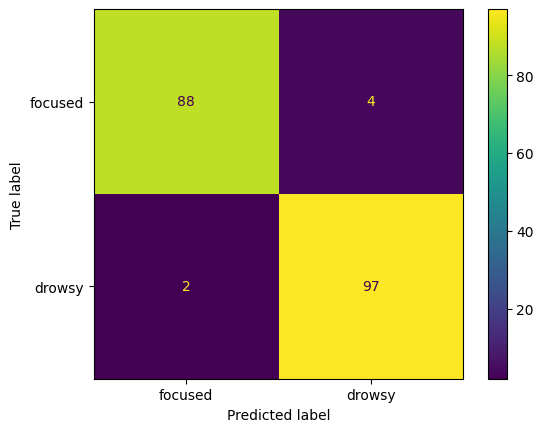

In [490]:
knn_cm = confusion_matrix(y_test, knn.predict(X_test))
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm,display_labels=display_labels)
print("KNN Matrix")
knn_disp.plot()

Decision Tree Classifier

In [329]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(dt.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(dt.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.0000
Accuracy of Decision Tree classifier on test set: 0.5969


DT Matrix


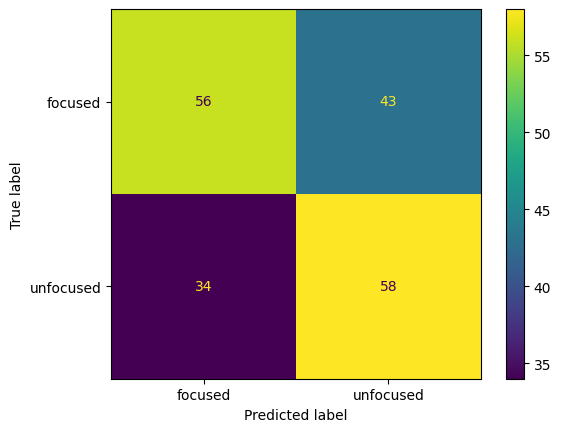

In [330]:
dt_cm = confusion_matrix(y_test, dt.predict(X_test))
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm,display_labels=display_labels)
print("DT Matrix")
dt_disp.plot()

Random Forest Classifier

In [299]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print('Accuracy of RandomForestClassifier classifier on training set: {:.4f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier classifier on test set: {:.4f}'
     .format(rf.score(X_test, y_test)))

Accuracy of RandomForestClassifier classifier on training set: 1.0000
Accuracy of RandomForestClassifier classifier on test set: 0.9686


/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_97420/1193651153.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)


DT Matrix


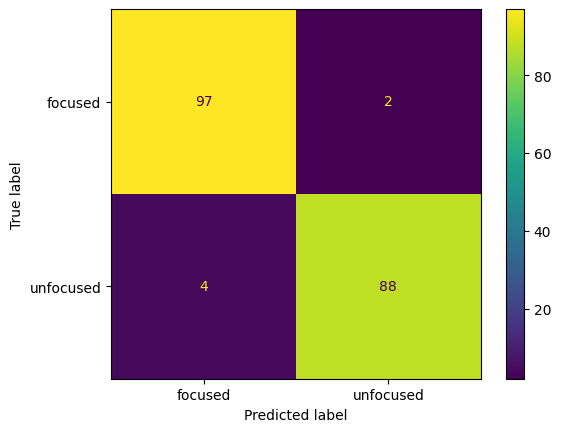

In [300]:
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels=display_labels)
print("DT Matrix")
rf_disp.plot()

Logistic Regression Classifier

In [325]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.7332
Accuracy of Logistic regression classifier on test set: 0.6754


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lr Matrix


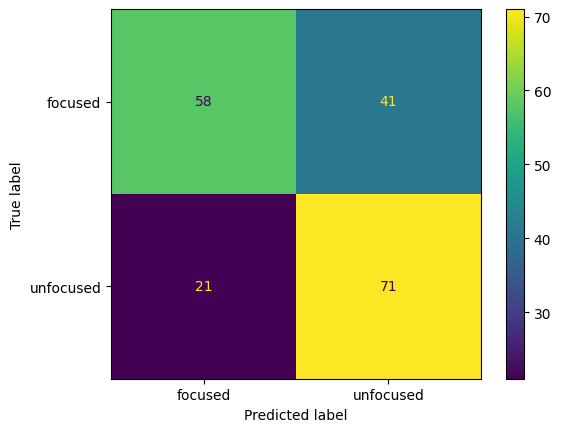

In [326]:
logreg_cm = confusion_matrix(y_test, logreg.predict(X_test))
logreg_disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm,display_labels=display_labels)
print("lr Matrix")
logreg_disp.plot()

SVM Classifier

In [491]:
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel='linear', degree=10, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=1)
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(svm.score(X_test, y_test)))


Accuracy of SVM classifier on training set: 1.0000
Accuracy of SVM classifier on test set: 0.9948


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Matrix


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

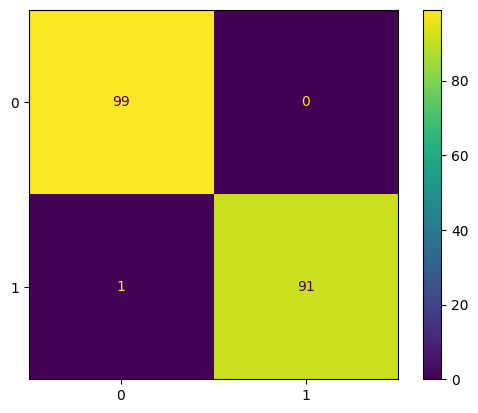

In [459]:
svm_cm = confusion_matrix(y_test, svm.predict(X_test))
display_labels = ["focused","unfocused",'drowsy']
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm,
                               display_labels=display_labels)
print("SVM Matrix")
svm_disp.plot()

Neural Network Classifier

In [248]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(activation='logistic',solver='adam', alpha=1e-2, learning_rate='adaptive', max_iter=1000000, hidden_layer_sizes=(40), random_state=1)
NN.fit(X_train, y_train)
print('Accuracy of NN classifier on training set: {:.4f}'
     .format(NN.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'
     .format(NN.score(X_test, y_test)))

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of NN classifier on training set: 0.9974
Accuracy of NN classifier on test set: 0.7435


NN Matrix


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

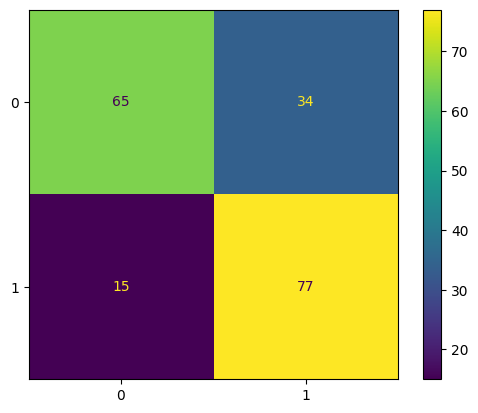

In [249]:
NN_cm = confusion_matrix(y_test, NN.predict(X_test))
NN_disp = ConfusionMatrixDisplay(confusion_matrix=NN_cm,display_labels=display_labels)
print("NN Matrix")
NN_disp.plot()

Gradient Boosting Classifier

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=1).fit(X_train, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.4f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.4f}'
     .format(clf.score(X_test, y_test)))

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of GradientBoostingClassifier on training set: 1.0000
Accuracy of GradientBoostingClassifier on test set: 0.6021


clf Matrix


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

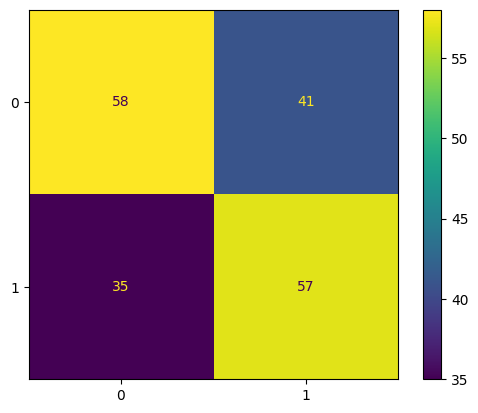

In [158]:
clf_cm = confusion_matrix(y_test, clf.predict(X_test))
clf_disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm,display_labels=display_labels)
print("clf Matrix")
clf_disp.plot()